In [7]:
import numpy as np
import pandas as pd   
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
df = pd.read_csv("Data/2018.csv")

In [4]:
df.FL_DATE = pd.to_datetime(df.FL_DATE, format="%Y-%m-%d")
df = df.set_index('FL_DATE')

In [5]:
df = df.loc['2018-01-01':'2018-03-01']

In [6]:
df.tail()

,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2018-03-01,UA,203,BOS,ORD,652,651.0,-1.0,20.0,711.0,853.0,...,179.0,198.0,162.0,867.0,0.0,0.0,18.0,0.0,0.0,NaN
2018-03-01,UA,202,ORD,OGG,1020,1028.0,8.0,45.0,1113.0,1606.0,...,567.0,583.0,533.0,4184.0,8.0,0.0,16.0,0.0,0.0,NaN
2018-03-01,UA,201,HNL,GUM,1510,1505.0,-5.0,20.0,1525.0,1855.0,...,475.0,473.0,450.0,3801.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,UA,200,GUM,HNL,735,744.0,9.0,12.0,756.0,1822.0,...,415.0,406.0,386.0,3801.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,UA,102,IAH,RDU,1940,1934.0,-6.0,14.0,1948.0,2247.0,...,161.0,139.0,119.0,1042.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.dtypes

OP_CARRIER              object
OP_CARRIER_FL_NUM        int64
ORIGIN                  object
DEST                    object
CRS_DEP_TIME             int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME             int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE       object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtype: object

In [8]:
df = pd.read_csv("Data/data_2018.csv", index_col=0)

In [32]:
df.columns[0:30]

Index(['OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'ORIGIN_ABE', 'ORIGIN_ABI', 'ORIGIN_ABQ',
       'ORIGIN_ABR', 'ORIGIN_ABY', 'ORIGIN_ACT', 'ORIGIN_ACV'],
      dtype='object')

In [16]:

X = df.drop(["TAXI_OUT","OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", 
"WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY", "CANCELLED", 
"CANCELLATION_CODE", "DIVERTED", "CRS_ELAPSED_TIME", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "DISTANCE", 
"CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"], axis=1)
print(X.shape)
X = X.to_numpy()


y = df["CARRIER_DELAY"].values


(295894, 692)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# # standardize input features
# X_train_mean = X_train.mean(axis=0)
# X_train_std = X_train.std(axis=0)
# X_train = (X_train - X_train_mean) / X_train_std

# X_test_mean = X_test.mean(axis=0)
# X_test_std = X_test.std(axis=0)
# X_test = (X_test - X_test_mean) / X_test_std

# # standardize target
# y_train_mean = y_train.mean()
# y_train_std = y_train.std()
# y_train = (y_train - y_train_mean) / y_train_std

# y_test_mean = y_test.mean()
# y_test_std = y_test.std()
# y_test = (y_test - y_test_mean) / y_test_std


KeyboardInterrupt: 

In [ ]:
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 198248
num test: 97646


In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [19]:

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)




corr, mae, rae, rmse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.094
MAE: 25.957
RMSE: 61.000
R2: 0.007


REALLY bad model

In [ ]:
X.shape[1]

First a model with TAXI_OUT, DESTINATION and ORIGIN as inpot with same regression coefficients

In [23]:
def model(X, obs=None):
    
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [70]:

X_train[:100]

array([[14.,  0.,  0., ...,  0.,  0.,  0.],
       [30.,  0.,  0., ...,  0.,  0.,  0.],
       [25.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [14.,  0.,  0., ...,  0.,  0.,  0.],
       [ 9.,  0.,  0., ...,  1.,  0.,  0.],
       [12.,  0.,  0., ...,  0.,  0.,  0.]])

In [24]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train[:500,:]).float()
y_train_small = torch.tensor(y_train[:500]).float()

In [25]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()


Sample: 100%|██████████| 1200/1200 [02:20,  8.53it/s, step size=2.88e-01, acc. prob=0.846]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.62      0.91      2.62      1.05      3.99   1852.07      1.00
   beta[0]      0.01      0.97      0.03     -1.61      1.57   1959.31      1.00
   beta[1]      0.05      1.02      0.02     -1.67      1.71   2631.88      1.00
   beta[2]      0.01      0.98      0.02     -1.59      1.58   2097.51      1.00
   beta[3]      0.03      0.98     -0.01     -1.54      1.65   1904.18      1.00
   beta[4]      0.03      0.97      0.07     -1.45      1.67    959.36      1.00
   beta[5]     -0.02      0.97     -0.01     -1.67      1.46   2198.31      1.00
   beta[6]      0.02      0.99      0.05     -1.61      1.59   1041.31      1.00
   beta[7]      0.02      1.03      0.03     -1.56      1.74   1575.87      1.00
   beta[8]     -0.01      0.96     -0.03     -1.36      1.78   2062.71      1.00
   beta[9]      0.00      1.02     -0.01     -1.58      1.61   2430.10      1.00
  beta[10]      0.01      0

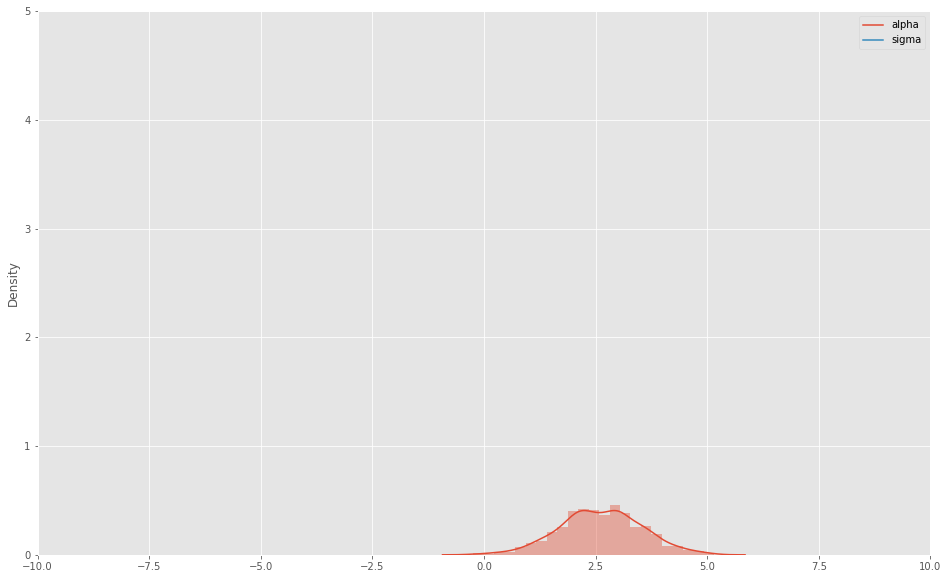

In [26]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.distplot(posterior_samples["alpha"])
sns.distplot(posterior_samples["sigma"])

# Alternate plotting due to deprecated distplot-function
#sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
#sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-10,10,0,5])
plt.show()


In [27]:
print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

y_hat = alpha_hat+np.dot(X_test,beta_hat)
y_hat = y_hat.numpy()

torch.Size([1000])
torch.Size([1000, 692])


In [28]:
# Convert back to the original scale

corr, mae, rae, rmse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.015
MAE: 20.170
RMSE: 63.551
R2: 0.000


Now a model with a gamma distribution on Taxi out, dependent on the ORIGIN

In [ ]:
def model(X, ind, n_ind, obs=None):
    #gp = pyro.sample("gp", dist.Gamma(k,theta))
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0.,1).to_event()) # Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(5.).to_event()) # Prior for the bias standard deviation

    #alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance

    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Gamma(alpha_mu, alpha_sigma).to_event(1)) # Draw the individual parameter for each individual

    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y